In [ ]:
#!git clone https://github.com/huggingface/transformers.git#


In [ ]:
#pip install transformers=="4.0.0"

In [2]:
from fastai.text.all import *
import torch
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
import pandas as pd
import glob

In [4]:
pretrained_weights = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [5]:
ids = tokenizer.encode('This is an example of text, and')
t = torch.LongTensor(ids)[None]
preds = model.generate(t)
tokenizer.decode(preds[0].numpy())


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"This is an example of text, and it's not a good one.\n\nThe first thing"

In [6]:
with open('../input/instagram-images-with-captions/instagram_data/captions_csv.csv', encoding="utf8", errors='ignore') as f:
    train=pd.read_csv(f,header=None)
train.head()

,0,1,2
0,Sr No,Image File,Caption
1,1,img/insta1,NaN
2,2,img/insta2,bye
3,3,img/insta3,"Ok, a few more... sorry I just had so much fun that day"
4,4,img/insta4,"This was one of my favorite shoots I’ve ever done! Thank you -a seriously badass woman, for shooting my cover! And thank you to everyone who asked a question for the interview 🤍"


In [15]:
train.shape


(20516, 1)

In [13]:
train.head()

,2
0,Caption
1,NaN
2,bye
3,"Ok, a few more... sorry I just had so much fun that day"
4,"This was one of my favorite shoots I’ve ever done! Thank you -a seriously badass woman, for shooting my cover! And thank you to everyone who asked a question for the interview 🤍"


In [31]:
train=train.dropna()
valid=train
train[2].values

array(['Caption', 'bye ',
       'Ok, a few more... sorry I just had so much fun that day ', ...,
       "I love me and Kylie's nail polish colors! ", 'Fammm ',
       'Disneyland! '], dtype=object)

In [32]:
all_texts = np.concatenate([train[2].values, valid[2].values])

all_texts.shape

(34202,)

In [33]:
def tokenize(text):
    toks = tokenizer.tokenize(text)
    return tensor(tokenizer.convert_tokens_to_ids(toks))

tokenized = [tokenize(t) for t in progress_bar(all_texts)]

class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        return x if isinstance(x, Tensor) else tokenize(x)
        
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [34]:
bs,sl = 4,256
splits = [range_of(train), list(range(len(train), len(all_texts)))]
tls = TfmdLists(tokenized, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
dls = tls.dataloaders(bs=bs, seq_len=sl)

In [35]:
dls.show_batch(max_n=2)

,text,text_
0,"Half cookies for me! 4 years now... Love my girls so much Sisters being at Robs house and seeing some really appropriate reading material... the second ones about a cat right? My bwide (say it out loud even if your a thug it’s cute) Yesterday was so much fun!! has been such a huge figure in my life. I love her humor, her grace and her heart! Check out the interview where I’m gushing over her the whole time! Guess who’s trying to be the family favorite… SUSHI!!!! Do your pets compete for attention when there’s a new 👶🏽 in the house?? Maybe she’s living a secret life?? What are your pets doing when you’re not at home? Tag with your pets secret style. Vivenne Westwood for the Webby's ""They lovin the crew"" She stays on the phone with me till I fall asleep and wakes me up with urth..","cookies for me! 4 years now... Love my girls so much Sisters being at Robs house and seeing some really appropriate reading material... the second ones about a cat right? My bwide (say it out loud even if your a thug it’s cute) Yesterday was so much fun!! has been such a huge figure in my life. I love her humor, her grace and her heart! Check out the interview where I’m gushing over her the whole time! Guess who’s trying to be the family favorite… SUSHI!!!! Do your pets compete for attention when there’s a new 👶🏽 in the house?? Maybe she’s living a secret life?? What are your pets doing when you’re not at home? Tag with your pets secret style. Vivenne Westwood for the Webby's ""They lovin the crew"" She stays on the phone with me till I fall asleep and wakes me up with urth.."
1,"restock on KylieSkin.com 🌴💗 So I’ve had the most amazing response to my fragrance and it’s selling out fast! I’m working with my factory to make sure that we can get more for you guys in time for the holidays! I am so so grateful to everyone who bought theirs and I’m seeing all your tweets saying you’ve received them already and are loving them!! Thank you guys!!! We still have limited quantities left, and I’ll keep you guys posted on the restock 💤 Yesterday was such a huge victory for the Armenian people when the US House Of Representatives acknowledged the Armenian Genocide! This photo was taken of me and my children this month in Armenia 🇦🇲 by Jackie Nickerson moody Happy Birthday I miss you! Best fwiends Me and my hair stylist from Sherri Hill 😝 I have a full crush on I'd really rather hover in","ock on KylieSkin.com 🌴💗 So I’ve had the most amazing response to my fragrance and it’s selling out fast! I’m working with my factory to make sure that we can get more for you guys in time for the holidays! I am so so grateful to everyone who bought theirs and I’m seeing all your tweets saying you’ve received them already and are loving them!! Thank you guys!!! We still have limited quantities left, and I’ll keep you guys posted on the restock 💤 Yesterday was such a huge victory for the Armenian people when the US House Of Representatives acknowledged the Armenian Genocide! This photo was taken of me and my children this month in Armenia 🇦🇲 by Jackie Nickerson moody Happy Birthday I miss you! Best fwiends Me and my hair stylist from Sherri Hill 😝 I have a full crush on I'd really rather hover in the"


In [36]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [37]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [38]:
learn.validate()

(#2) [4.408637523651123,82.1574478149414]

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.14454397559165955)

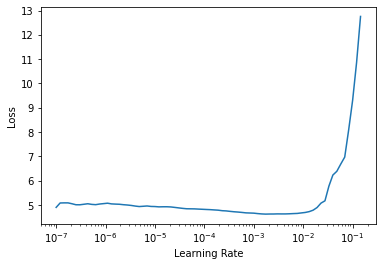

In [39]:
learn.path=Path('/')
learn.lr_find()

In [40]:
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,4.129982,3.718884,41.218357,01:06
1,3.831470,3.424949,30.721083,01:06
2,3.571820,3.221831,25.073997,01:06
3,3.378442,3.113788,22.506140,01:06
4,3.282147,3.089881,21.974472,01:06


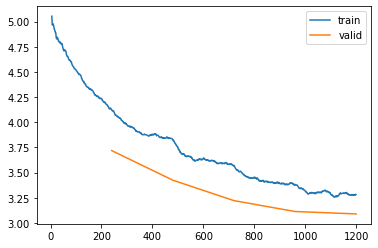

In [41]:
learn.recorder.plot_loss()

In [45]:
prompt = "well "
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp,
                             do_sample=True, 
                             max_length=30,
                             min_length=5,
                             top_k=40,
                             num_return_sequences=1)
tokenizer.decode(preds[0].cpu().tolist())


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"well My birthday boy is here! You're the definition of perfection and we have to take it all back to him!!!!! Happy birthday you are the"

In [ ]:
learn.export('/kaggle/working/instagram.pkl')

In [ ]:
#device=torch.device('cpu:0')
#learn.model.to(device)